In [285]:
import pandas as pd
import numpy as np
import datetime as dt
import spacy
import string
import time
import demoji
import re
import pickle
import scipy
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import AgglomerativeClustering
from nltk.chunk import ne_chunk
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')

In [305]:
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

def topwords(topicstoterms):
    topictop10 = pd.DataFrame()
    transposed = topicstoterms.transpose()
    for i in range(transposed.shape[1]):
        topictop10[i] = transposed[i].sort_values(ascending = False)[0:10].index
    return topictop10

def applyNMF(dtm, vectorizer, n_topics):
    nmf = NMF(n_topics, init = "nndsvd")
    nmf.fit(dtm)
    return nmf, pd.DataFrame(nmf.components_, columns = vectorizer.get_feature_names_out())

def topic_plot(topics_dtm, topics, filename):
    topic_count = []
    for col in topics_dtm.columns:
        topic_count.append(sum(topics_dtm[col].astype(bool)))
        topic_dict = dict(zip(topics.values(), topic_count))
    topic_dict = dict(sorted(topic_dict.items(), key=lambda item: item[1], reverse = True))
    plt.bar(topic_dict.keys(), topic_dict.values())
    plt.title("Distribution of Topics", fontsize = 18)
    plt.xlabel("Topics", fontsize = 18)
    plt.ylabel("Topic Count", fontsize = 18)
    plt.xticks(rotation = 90)
    plt.savefig(filename, bbox_inches = "tight")
    plt.show()
    
def custom_stopwords(corpus):
    tokenized_corpus = list(nlp.pipe(corpus))
    
    custom_stopwords = []
    for doc in tokenized_corpus:
        for token in doc:
            if (token.is_stop == True) | (token.pos_ in ["PUNCT", "SYM", "AUX"]) | (token.is_ascii == False):
                custom_stopwords.append(token.lower_)
    return custom_stopwords

def spacy_tokenizer(sentence):
    all_tokens = nlp(sentence)
    
    tokens = [token.lemma_.lower().strip() for token in all_tokens if (token.pos_ in {"NOUN", "PROPN", "VERB"} and token.is_quote == False and len(token) > 1)]
    lemmatized = [word.strip("\"'") for word in tokens if word not in stopwords]
    return lemmatized

def remove_emoji(sentence):
    emojis = demoji.findall(sentence)
    for emoji in emojis.keys():
        sentence = sentence.replace(emoji, '')
    return sentence

def cosine_sim(a, b):
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        return 1
    else:
        return 1-np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [3]:
df = pd.read_csv("corpus.csv")
df["title"].update(pd.Series(["Canada will list the Proud Boys movement as a terrorist group",
                         "Scottish Parliament to hold vote on Unexplained Wealth Order into Donald Trump's finances | MSPs will be asked to vote this week on whether the Scottish Government should pursue an Unexplained Wealth Order (UWO) to investigate the source of financing for Donald Trump’s Scottish resorts.",
                         "With reports that Donald Trump may fly to Scotland after he leaves office, BrewDog have started a petition to rename Prestwick Airport ‘Joe Biden International’.", 
                         "No, Trump won’t be golfing in Scotland on Inauguration Day, First Minister Nicola Sturgeon says | Pandemic travel ban applies to President Trump as much as anybody else, the Scotland’s head of government says",
                         "Russian Media Wants Moscow to Grant Asylum to Trump",
                         "Bolsonaro abandons 'friend' Trump after 2020 election, says he's 'not the most important person in the world'"],
                         index = [9296, 9331, 9602, 9892, 10425, 11068]))
corpus = []
for sentence in df["title"]:
    sentence = remove_emoji(sentence)
    for c in sentence:
        if ord(c) >= 128:
            sentence = sentence.replace(c, ' ')
    corpus.append(sentence.replace('\n', '').replace('\t', '').replace('\r', '').replace('  ', ' '))
corpus = pd.Series(corpus)

In [4]:
#stopwords = set(custom_stopwords(corpus))
stopwords = nlp.Defaults.stop_words

# CountVectorizer + NLTK Lemmatizer

In [163]:
vectorizer = CountVectorizer(tokenizer = LemmaTokenizer(), stop_words = "english", token_pattern='\\b(\\w+[\\.,]?\\w+)\\b', max_features = 15000)
X = vectorizer.fit_transform(corpus).toarray()
dtm_cv = pd.DataFrame(X, columns = vectorizer.get_feature_names_out())

/home/chanjunho/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [17]:
nmf, topicstoterms = applyNMF(dtm_cv, vectorizer, 8)

/home/chanjunho/.local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [50]:
topictop10 = topwords(topicstoterms)
topictop10

,0,1,2,3,4,5,6,7
0,",",.,’,','','s,:,say
1,new,ha,s,-,``,world,russian,trump
2,-,wa,‘,uk,said,ha,report,u
3,year,year,t,warns,-,china,u,russia
4,ha,“,-,n't,president,country,ukraine,russian
5,said,”,“,climate,climate,president,thread,ukraine
6,world,-,”,|,people,new,trump,president
7,including,people,world,'we,n't,-,day,u.s.
8,report,said,china,johnson,...,russia,new,ha
9,china,government,trump,boris,right,trump,live,donald


In [38]:
topics_dtm = pd.DataFrame(nmf.transform(dtm_cv))

In [43]:
topics = {0: "General Politics", 
           1: "Russia",
           2: "Western Affairs", 
           3: "Trump", 
           4: "Covid", 
           5: "Protests", 
           6: "Asia (Primarily China)", 
           7: "Prison"}

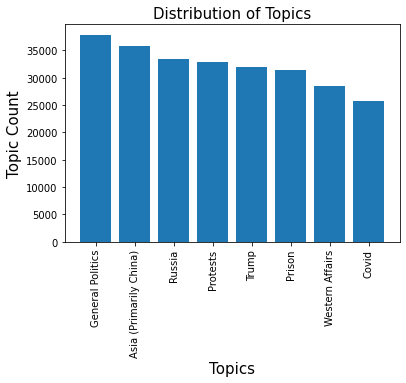

In [44]:
topic_plot(topics_dtm, topics, "topic_counts.png")

In [45]:
corpus[topics_dtm[topics_dtm[0] != 0].index]

0        A village is liberated in the Chernihiv region...
1        Russian conspiracy theory that US is building ...
2        Russia has killed more civilians than soldiers...
3        "Any lawless decision by Russia to seize the a...
4        Trendy restaurants in Kyiv switch to cook for ...
                               ...                        
46404    Three Americans go to Uganda and teach thousan...
46405    Another reason Dubai will never be a holiday \...
46406    These images depict the untouched stomach cont...
46407           New airport scanners break child porn laws
46408    Way to end 09 on a high note: No U.S. combat-r...
Name: title, Length: 37912, dtype: object

***

***

***

# CountVectorizer w/ Custom Stop Words & SpaCy Lemmatization

In [306]:
start_time = time.time()
cv = CountVectorizer(tokenizer = spacy_tokenizer)
X_cv = cv.fit_transform(corpus).toarray()
dtm_spacycv = pd.DataFrame(X, columns = cv.get_feature_names_out())
sps_spacycv = scipy.sparse.csr_matrix(dtm_spacycv)
print(f"Runtime: {(time.time() - start_time)//60}m and {round((time.time() - start_time) - 60*(time.time() - start_time)//60)}s")

Runtime: 4.0m and 1s


In [319]:
start_time = time.time()
nmfcv10, nmfcv10_topicstoterms = applyNMF(sps_spacycv, cv, 20)
print(f"Runtime: {(time.time() - start_time)//60}m and {round((time.time() - start_time) - 60*(time.time() - start_time)//60)}s")

Runtime: 0.0m and 1s


/home/chanjunho/.local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [321]:
topictop10 = topwords(nmfcv10_topicstoterms)
topictop10

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,saudi,trump,russia,year,china,world,police,government,climate,korea,president,people,ban,u.s,find,woman,report,coronavirus,country,kill
1,arabia,donald,ukraine,time,taiwan,war,hong,uk,change,north,putin,die,use,official,study,man,use,day,germany,attack
2,child,administration,putin,jail,hong,leader,kong,minister,scientist,south,vladimir,thousand,plastic,canada,scientist,rape,case,case,minister,isis
3,war,official,war,prison,kong,news,protest,use,warn,un,donald,want,law,war,use,right,un,death,united,force
4,khashoggi,campaign,sanction,sentence,beijing,cup,arrest,brexit,crisis,kim,leader,city,eu,iran,discover,law,accord,test,plan,strike
5,right,house,invasion,man,sea,health,protester,plan,australia,jong,bolsonaro,life,court,troop,water,protest,reveal,health,canada,civilian
6,abuse,mueller,warn,girl,uighur,bank,officer,pay,action,missile,brazil,india,france,force,body,court,news,die,power,state
7,journalist,iran,nato,record,trade,use,law,johnson,un,test,war,work,germany,state,time,abortion,child,pandemic,india,shoot
8,oil,claim,attack,scientist,warn,time,thousand,company,paris,japan,ukraine,live,animal,sanction,researcher,sex,time,covid-19,right,soldier
9,arm,deal,troop,end,xi,organization,fire,boris,study,fire,state,home,import,united,life,force,mueller,vaccine,japan,man


In [322]:
start_time = time.time()
nmfcv10_topics_dtm = pd.DataFrame(nmfcv10.transform(sps_spacycv))
topics = {0: "Death", 
          1: "Trump/U.S.",
          2: "Russia/Ukraine", 
          3: "Jail/Prison", 
          4: "Asia", 
          5: "World News",
          6: "Hong Kong Protests",
          7: "U.K.",
          8: "Climate Change", 
          9: "North Korea"}
print(f"Runtime: {(time.time() - start_time)//60}m and {round((time.time() - start_time) - 60*(time.time() - start_time)//60)}s")

Runtime: 0.0m and 0s


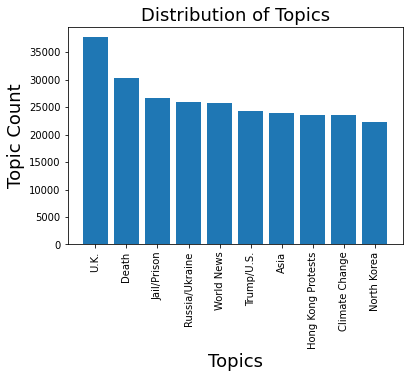

In [310]:
topic_plot(nmfcv10_topics_dtm, topics, "nmfcv10_topic_counts.png")

# TFIDF w/ Custom Stop Words & SpaCy Lemmatization

In [145]:
start_time = time.time()
tfidf = TfidfVectorizer(tokenizer = spacy_tokenizer)
X_tfidf = tfidf.fit_transform(corpus).toarray()
dtm_spacytfidf = pd.DataFrame(X_tfidf, columns = tfidf.get_feature_names_out())
sps_spacytfidf = scipy.sparse.csr_matrix(dtm_spacytfidf)
print(f"Runtime: {(time.time() - start_time)//60}m and {round((time.time() - start_time) - 60*(time.time() - start_time)//60)}s")

Runtime: 4.0m and 1s


In [146]:
start_time = time.time()
nmftfidf10, nmftfidf10_topicstoterms = applyNMF(sps_spacytfidf, tfidf, 10)
print(f"Runtime: {(time.time() - start_time)//60}m and {round((time.time() - start_time) - 60*(time.time() - start_time)//60)}s")

Runtime: 0.0m and 1s


In [147]:
topictop10 = topwords(nmftfidf10_topicstoterms)
topictop10

,0,1,2,3,4,5,6,7,8,9
0,ban,russia,trump,user,korea,hong,china,thread,world,year
1,uk,ukraine,president,delete,north,kong,coronavirus,invasion,climate,kill
2,government,putin,donald,facebook,south,protest,case,day,change,woman
3,use,war,u.s,datum,un,police,taiwan,worldnews,scientist,man
4,eu,sanction,iran,google,kim,protester,u.s,ukraine,warn,attack
5,canada,u.s,official,account,missile,arrest,report,tension,un,isis
6,country,nato,administration,internet,jong,thousand,warn,february,country,child
7,brexit,troop,putin,twitter,launch,law,japan,case,study,saudi
8,minister,warn,house,post,test,rally,death,iii,leader,people
9,law,attack,mueller,company,japan,security,outbreak,week,crisis,death


In [148]:
start_time = time.time()
nmftfidf10_topics_dtm = pd.DataFrame(nmftfidf10.transform(sps_spacytfidf))
topics = {0: "U.K.", 
          1: "Russia/Ukraine",
          2: "Trump/U.S.", 
          3: "Internet", 
          4: "North Korea", 
          5: "Hong Kong Protests",
          6: "China",
          7: "Ukraine Megathreads",
          8: "Climate Change", 
          9: "Saudi Arabia"}
print(f"Runtime: {(time.time() - start_time)//60}m and {round((time.time() - start_time) - 60*(time.time() - start_time)//60)}s")

Runtime: 0.0m and 0s


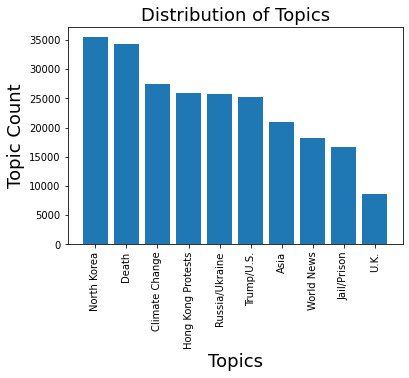

In [311]:
topic_plot(nmftfidf10_topics_dtm, topics, "nmftfidf10_topic_counts.png")

# Testing

In [246]:
def recommend_posts(new_post, vectorizer, model, train_dtm):
    X_test = vectorizer.transform([new_post]).toarray()
    dtm_test = pd.DataFrame(X_test, columns = vectorizer.get_feature_names_out())
    sps_test = scipy.sparse.csr_matrix(dtm_test)
    post = np.array(pd.DataFrame(model.transform(sps_test))).flatten()
    print(post)
    distances = []
    for i in range(train_dtm.shape[0]):
        distances.append(cosine_sim(post, train_dtm.iloc[i,:]))
    distances = pd.Series(distances).sort_values()
    return pd.DataFrame(np.array([corpus[distances[:10].index], distances[:10]]).T, columns = ["title", "cosine_similarity"], index = distances[:10].index)

In [150]:
df_test = pd.read_csv("test_corpus.csv")
corpus_test = df_test["title"]

## CountVectorizer
### Using rows 616, 343, 291, 200, 637

In [314]:
corpus_test[616]

"A 4th dose of Covid-19 vaccine will be needed, Pfizer's CEO says, but the company is working on a shot to handle all variants"

In [313]:
recommend_posts(corpus_test[616], cv, nmfcv10, nmfcv10_topics_dtm)

[0.00387948 0.         0.         0.00066422 0.0021332  0.00617081
 0.         0.03060848 0.00915192 0.00060098]


,title,cosine_similarity
9021,Dozens catch Covid at indoor conference hosted...,0.002025
6422,Pfizer data shows vaccine protection remains r...,0.003139
29974,11 vaccines will be mandatory in France starti...,0.003804
31661,New Zealand anger as pristine lakes tapped for...,0.004035
25570,"As Global 1% Seize Economy's Gains, 'Unprecede...",0.004819
30447,70% of Chinese companies fail air pollution in...,0.005056
6077,Indonesia reports two new Javan rhino calves i...,0.005132
6238,Dr. Fauci said the unvaccinated should think o...,0.005263
17046,Water bomber crash reported after C130 Hercule...,0.005532
9058,Seafood firm loses $20m vessel after trawling ...,0.005955


In [238]:
recommend_posts(corpus_test[616], tfidf, nmftfidf10, nmftfidf10_topics_dtm)

,title,cosine_similarity
7207,mRNA vaccine yields full protection against ma...,0.005273
6649,Australia to deport Britain's Katie Hopkins af...,0.007111
7261,Half of the Netherlands biggest pension funds ...,0.007477
13796,Keir Starmer Shames A Proud Boris Johnson Over...,0.00874
8012,Pope Francis backs vaccine patents waiver to e...,0.011381
10838,Covid-19 mink variants discovered in humans in...,0.01294
12125,"In response to COVID, Italy gives a 110% tax c...",0.013023
14641,Governments should not use taxpayer cash to re...,0.01403
22014,"Telstra blocks access to 4chan, 8chan, LiveLea...",0.014403
8967,First vaccine to fully immunize against malari...,0.014641


In [298]:
all_words = ""
for post in corpus:
    all_words += "".join(post.lower())+" "
word_cloud = WordCloud(width = 800, height = 450, background_color = 'white', stopwords = stopwords, min_font_size = 10).generate(all_words)

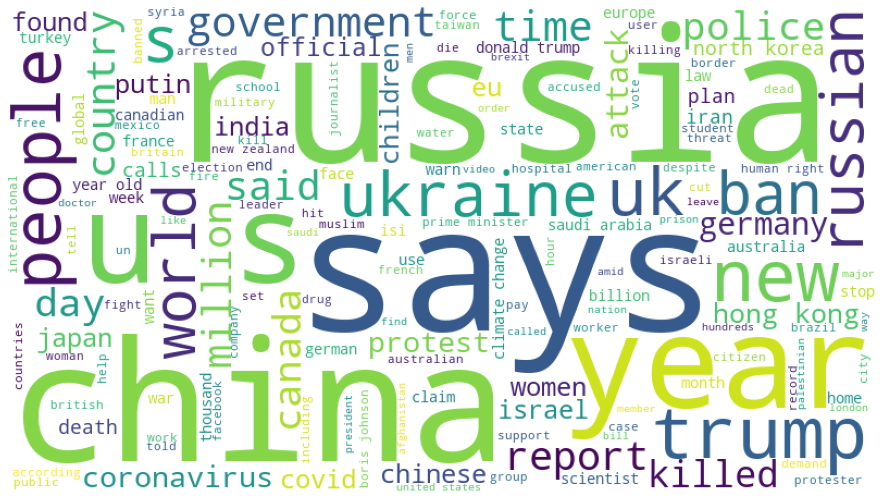

In [304]:
plt.figure(figsize = (16,9))
plt.imshow(word_cloud)
plt.axis("off")
plt.savefig("word_cloud.png")
plt.show()